# My First Model

This guide will walk you through creating and training your first simulation-based inference model using GenSBI. We will cover the essential steps, from defining a simulator to training a neural density estimator.

As a frist step, make sure gensbi is installed in your environment. If you haven't done so yet, please refer to the [Installation Guide](/getting_started/installation) before proceeding, or simply run:

```bash
pip install git+https://github.com/aurelio-amerio/GenSBI.git
```

Then we need to import all the necessary modules from GenSBI and other libraries. If you don't have a gpu available, you can set the device to "cpu" instead of "cuda", but training will be slower.

In [1]:
import os

# Set JAX backend (use 'cuda' for GPU, 'cpu' otherwise)
os.environ["JAX_PLATFORMS"] = "cuda"

import grain
import numpy as np
import jax
from jax import numpy as jnp
from numpyro import distributions as dist
from flax import nnx

from gensbi.recipes import Flux1FlowPipeline
from gensbi.models import Flux1, Flux1Params

from gensbi.utils.plotting import plot_marginals
import matplotlib.pyplot as plt

W1216 22:54:27.585274  819313 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1216 22:54:27.591028  819175 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


## The simulator

 The first step in simulation-based inference is to define a simulator function that generates data given parameters. In this example, we will create a simple simulator that generates data from a Gaussian distribution with a mean defined by the parameters.

The simulator takes in 3 parameters (theta) and returns 3 observations (xs). 

In the context of posterior density estimation, the `theta` parameters are the observations (what we want to model) and the `xs` are the conditions (the data we condition on, which we use to detemrine `theta`).

In [2]:

obs_dim = 3 # dimension of the observation (theta), that is the simulator input shape
cond_dim = 3 # dimension of the condition (xs), that is the simulator output shape
joint_dim = obs_dim + cond_dim # dimension of the joint (theta, xs), useful later

def _simulator(key, thetas):

    xs = thetas + 1 + jax.random.normal(key, thetas.shape) * 0.1

    thetas = thetas[..., None]
    xs = xs[..., None]

    # when making a dataset for the joint pipeline, thetas need to come first
    data = jnp.concatenate([thetas, xs], axis=1)

    return data

Now we define a prior distribution over the parameters. For simplicity, we will use a uniform prior over a specified range.

In [3]:
theta_prior = dist.Uniform(
    low=jnp.array([-2.0, -2.0, -2.0]), high=jnp.array([2.0, 2.0, 2.0])
)

For simpliciy, we define a simulator which samples from the prior internally.

In [4]:
def simulator(key, nsamples):
    theta_key, sample_key = jax.random.split(key, 2)
    thetas = theta_prior.sample(theta_key, (nsamples,))

    return _simulator(sample_key, thetas)

## The dataset

We create a dataset by running the simulator multiple times with parameters sampled from the prior distribution. This dataset will be used to train the neural density estimator.

GenSBI can work with any dataset that provides an iterator to obtain couples of (parameters, observations). 
For numerical efficiency and ease of use, it is convenient to create a Jax-based datset using `grain`, for high efficiency data-loading and prefetching.

In [5]:
# Define your training and validation datasets.
train_data = simulator(jax.random.PRNGKey(0), 10_000)
val_data = simulator(jax.random.PRNGKey(1), 2000)

In [6]:
# utility function to split data into observations and conditions
def split_obs_cond(data):
    return data[:, :obs_dim], data[:, obs_dim:]  # assuming first dim_obs are obs, last dim_cond are cond

We create a grain dataset with batch size = 128. The larger the batch size, the more stable the training.

Adjust according to your hardware capabilities, e.g. GPU memory (try experimenting with 256, 512, 1024, etc).


In [7]:
batch_size = 128

train_dataset_grain = (
    grain.MapDataset.source(np.array(train_data))
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(batch_size)
    .map(split_obs_cond)
    .mp_prefetch() # If you use prefetching in a .py script, make sure your python script is thread safe, see https://docs.python.org/3/library/multiprocessing.html
)

val_dataset_grain = (
    grain.MapDataset.source(np.array(val_data))
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(batch_size)
    .map(split_obs_cond)
    .mp_prefetch() 
)

These datasets are innfinite dataloaders, meaning that they will keep providing data as long as needed.
You can get samples from the dataset using:

In [8]:
iter_dataset = iter(train_dataset_grain)
obs,cond = next(iter_dataset)  # returns a batch of (observations, conditions)
print(obs.shape, cond.shape)  # should print (batch_size, obs_dim, 1), (batch_size, cond_dim, 1)

(128, 3, 1) (128, 3, 1)


## The Model

We define a `Flux1` model and pipeline. `Flux1` is a versatile transformer-based architecture suitable for various (complex) SBI tasks. Although for this problem a simpler architecture would suffice, we use `Flux1` to illustrate how to set up the main components of a GenSBI model.

In [9]:
# define the model parameters
params = Flux1Params(
    in_channels=1, # each observation/condition feature has only one channel (the value itself)
    vec_in_dim=None,
    context_in_dim=1, 
    mlp_ratio=3, # default value
    num_heads=2, # number of transformer heads
    depth=4, # number of double-stream transformer blocks
    depth_single_blocks=8, # number of single-stream transformer blocks
    axes_dim=[ 10,], # number of features per transformer head
    qkv_bias=True, # default
    obs_dim=obs_dim, # dimension of the observation (theta)
    cond_dim=cond_dim, # dimension of the condition (xs)
    theta=10*joint_dim, # dimension of the ROPE embedding space. A good rule of thumb is to set it to 10 times the joint dimension
    rngs=nnx.Rngs(default=42), # random number generator seed
    param_dtype=jnp.float32, # data type of the model parameters. 
)

In [10]:
# Intantiate the pipeline
pipeline = Flux1FlowPipeline(
    train_dataset_grain,
    val_dataset_grain,
    obs_dim,
    cond_dim,
    params=params,
)

## Training

Now we train the model using the defined pipeline. We specify the number of epochs and the random seed for reproducibility.

In [11]:
rngs = nnx.Rngs(42)

In [ ]:
pipeline.train(
    rngs, nsteps=5000, save_model=False
)  # if you want to save the model, set save_model=True

100%|██████████| 5000/5000 [09:59<00:00,  8.34it/s, counter=0, loss=0.1598, ratio=0.9114, val_loss=0.1457]


Saved model to checkpoint


([Array(0.40291947, dtype=float32),
  Array(0.23632641, dtype=float32),
  Array(0.23836574, dtype=float32),
  Array(0.2002398, dtype=float32),
  Array(0.19798928, dtype=float32),
  Array(0.18915024, dtype=float32),
  Array(0.16597998, dtype=float32),
  Array(0.18442385, dtype=float32),
  Array(0.16876286, dtype=float32),
  Array(0.17936002, dtype=float32),
  Array(0.17662618, dtype=float32),
  Array(0.18892698, dtype=float32),
  Array(0.16717045, dtype=float32),
  Array(0.16670851, dtype=float32),
  Array(0.16970727, dtype=float32),
  Array(0.18653607, dtype=float32),
  Array(0.15726991, dtype=float32),
  Array(0.16580977, dtype=float32),
  Array(0.1788384, dtype=float32),
  Array(0.15764983, dtype=float32),
  Array(0.16805986, dtype=float32),
  Array(0.16925089, dtype=float32),
  Array(0.16603029, dtype=float32),
  Array(0.1622884, dtype=float32),
  Array(0.15748796, dtype=float32),
  Array(0.15501256, dtype=float32),
  Array(0.16150434, dtype=float32),
  Array(0.16583696, dtype=float

If you don't want to waste time retraining the model, you can directly load a pre-trained model for this example using this code:

In [12]:
pipeline.restore_model()

Restored model from checkpoint


## Sampling from the posterior

In order to sample from the posterior distribution given new observations, we use the trained model's `sample` method. We provide the observation for which we want to reconstruct the posterior, and specify the number of samples we want to draw from the posterior.

In [13]:
new_sample = simulator(jax.random.PRNGKey(20), 1) # the observation for which we want to reconstruct the posterior

true_theta = new_sample[:, :obs_dim, :]  # The input used for the simulation, AKA the true value
x_o = new_sample[:, obs_dim:, :]  # The observation from the simulation for which we want to reconstruct the posterior

Now we sample from the posterior:

In [14]:
samples = pipeline.sample(rngs.sample(), x_o, nsamples=100_000)

Once we have the samples, we display the marginal distributions:

<Figure size 640x480 with 0 Axes>

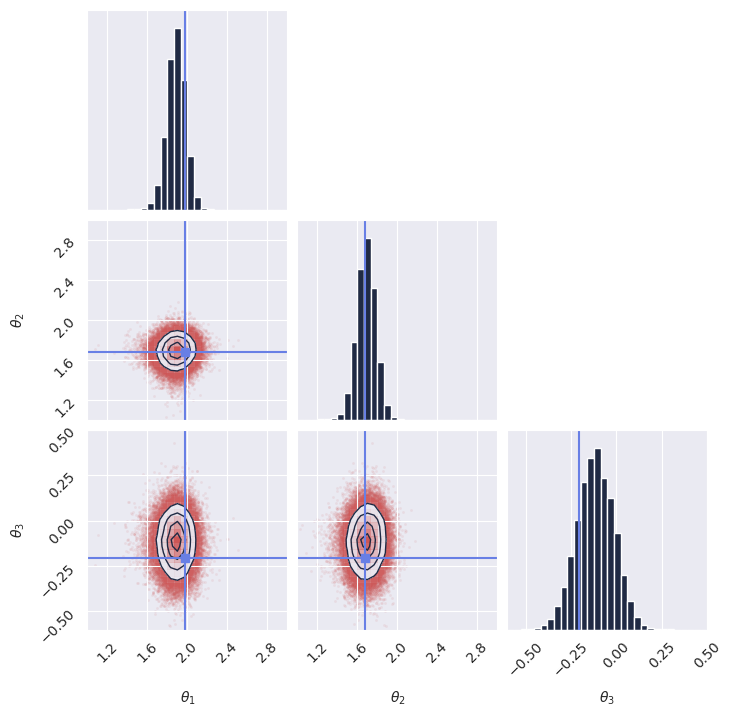

In [15]:
plot_marginals(
    np.array(samples[..., 0]), gridsize=30, true_param=np.array(true_theta[0, :, 0]), range = [(1, 3), (1, 3), (-0.6, 0.5)]
)
# plt.savefig("conditional_flow_pipeline_marginals.png", dpi=100, bbox_inches="tight") # uncomment to save the figure
plt.show()

## Next steps

Congratulations! You have successfully created and trained your first simulation-based inference model using GenSBI. You can now experiment with different simulators, priors, and neural density estimators to explore more complex inference tasks.

For more examples, please refer to the [Examples Section](/examples) of the GenSBI documentation.

As a step forward, you might want to explore how to validate the performance of your trained model using techniques such as simulation-based calibration (SBC) or coverage plots. These methods help assess the quality of the inferred posterior distributions and ensure that your model is providing accurate uncertainty estimates.

## Posterior calibration tests

In this section we perform posterior calibration tests using Simulation-Based Calibration (SBC) and Targeted At Random Parameters (TARP) methods to evaluate the quality of our trained model's posterior estimates.

GenSBI does not provide built-in functions for SBC and TARP, but we can leverage the `sbi` package to perform these tests. 
In order to install `sbi`, as well as the compatibility layer, please run:

```bash
pip install git+https://github.com/aurelio-amerio/GenSBI-validation.git --extra-index-url https://download.pytorch.org/whl/cpu
```

For a full overiew of posterior calibration tests, refer to the [sbi documentation](https://sbi.readthedocs.io/en/latest/how_to_guide.html#diagnosticsl). 

In [30]:
# imports
from gensbi_validation import PosteriorWrapper
from sbi.analysis.plot import sbc_rank_plot
from sbi.diagnostics import check_sbc, check_tarp, run_sbc, run_tarp
from sbi.analysis.plot import plot_tarp

import torch

We wrap the pipeline posterior into a `PosteriorWrapper`, which provides an interface compatible with `sbi`.

In [17]:
posterior = PosteriorWrapper(pipeline, rngs=nnx.Rngs(1234))

We sample 200 new observations from the simulator to perform the calibration tests.
It is instrumental that we use a seed different from the one used during training to avoid biased results.

In [ ]:
key = jax.random.PRNGKey(1234)
# sample the dataset
test_data = simulator(jax.random.PRNGKey(1), 200)

# split in thetas and xs
thetas = test_data[:, :obs_dim, :] # (200, 3, 1)
xs = test_data[:, obs_dim:, :] # (200, 3, 1)

# flatten the dataset. sbi expects 2D arrays of shape (num_samples, features), while our data is 3D of shape (num_samples, dim, channels).
# we reshape a sample of size (dim, channels) into a vector of size (dim * channels)
thetas = posterior._ravel(thetas) # (200, 3)
xs = posterior._ravel(xs) # (200, 3)

# convert to torch tensors
thetas = torch.Tensor(np.array(thetas))
xs = torch.Tensor(np.array(xs))

### SBC

In [26]:
ranks, dap_samples = run_sbc(thetas, xs, posterior)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)

Calculating ranks for 200 SBC samples:   0%|          | 0/200 [00:00<?, ?it/s]

In [27]:
print(check_stats)

{'ks_pvals': tensor([0.0035, 0.1284, 0.0850]), 'c2st_ranks': tensor([0.5100, 0.5150, 0.5525], dtype=torch.float64), 'c2st_dap': tensor([0.4800, 0.5200, 0.5450], dtype=torch.float64)}


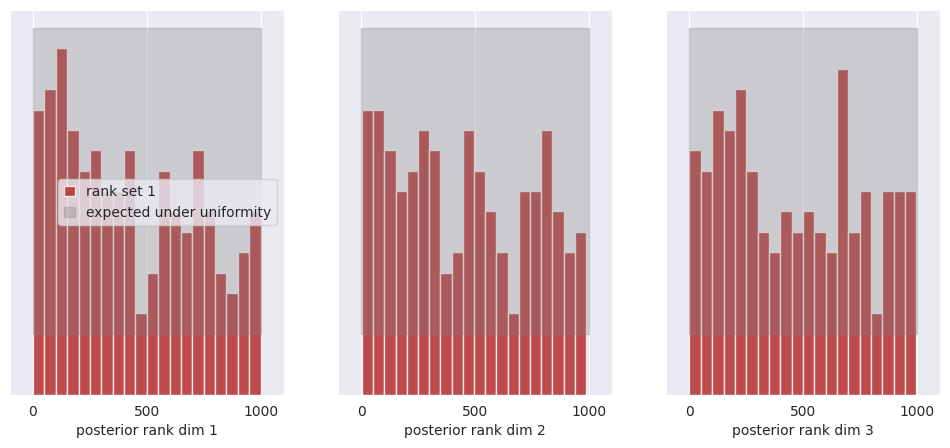

In [29]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="hist", num_bins=20)
plt.show()

See the SBI tutorial [https://sbi.readthedocs.io/en/latest/how_to_guide/16_sbc.html](https://sbi.readthedocs.io/en/latest/how_to_guide/16_sbc.html) for more details on SBC.

### TARP

In [22]:
ecp, alpha = run_tarp(
    thetas,
    xs,
    posterior,
    references=None,  # will be calculated automatically.
    num_posterior_samples=1000,
)

In [23]:
atc, ks_pval = check_tarp(ecp, alpha)
print(atc, "Should be close to 0")
print(ks_pval, "Should be larger than 0.05")

0.49899962544441223 Should be close to 0
0.999115261755522 Should be larger than 0.05


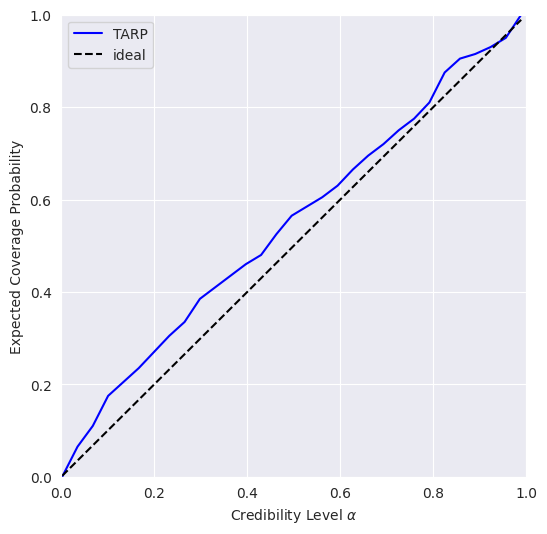

In [25]:
plot_tarp(ecp, alpha)
plt.show()

If the blue curve is above the diagonal, then the posterior estimate is under-confident. If it is under the diagonal, then the posterior estimate is over confident.

This means that our model is slightly under-confident. 
The reason for this is that we trained the model which is over-parametrized on a reduced number of simulations, with a small batch size and for a short time. Increasing the batch size and the number of training steps should improve the results. (TODO check and provide better numbers to achieve good results).

See [https://sbi.readthedocs.io/en/latest/how_to_guide/17_tarp.html](https://sbi.readthedocs.io/en/latest/how_to_guide/17_tarp.html) for more details on TARP.